# Estimating Assessed Value of Properties    Using the Zillow Dataset

Cris Giovanoni  
October 21, 2019
___

## Notes  
  
### Assumptions
- Square footage accounted all living, finished spaces. The values **excluded** the following spatial areas:
  - Basement
  - Garage
  - Yard
  - Entire lot
- Types of Single Unit housing included in the analysis:
   - 261	Single Family Residential
   - 262	Rural Residence
   - 263	Mobile Home
   - 264	Townhouse
   - 265	Cluster Home
   - 268	Row House
   - 269	Planned Unit Development
   - 273	Bungalow
   - 275	Manufactured, Modular, Prefabricated Homes
   - 276	Patio Home

### Workflow
- I. Create baseline model with three features - square footage, bathroom count, and bedroom count
- II. Create Ω model, going through entire pipeline
- III. Evaluate baseline and model and Ω model using test data

### Packages

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, explained_variance_score
from math import sqrt


import zillow_util as util

In [2]:
# dist = util.get_zillow_dist()

In [3]:
# dist.head()

In [4]:
# fips = pd.read_excel('fipxl.xlsx', sheet_name='fips_codes')

In [5]:
# fips.head()

In [6]:
# fips_dist = (pd.merge(dist,fips, left_on=dist.fips, right_on=fips.fips, how='left')

In [7]:
# fips_dist.

---
## I. Create Baseline Model

Get data from SQL and filter data with the following conditions:
tk


In [8]:
zillow = util.filter_zillow_baseline(util.get_sql_zillow())

Separate the features (X) and target (y) columns. Then, split data to train and test, resulting to four data frames with X and y separated and partitioned into two.

In [9]:
X = zillow[["sqft","bathcnt","bedcnt"]]
y = zillow.propvalue

In [10]:
X_train, X_test, y_train, y_test = util.split_my_data(X, y, 0.7)

Scale train and test data with all X.  
Scaled X train data will be fitted into to the model later.  
Scaled X test data will be used post-modelling phase to test the baseline model.

In [49]:
scaled_X_train, scaled_X_test, standard_scaler = util.standard_scaler(X_train, X_test)

Create a linear model with train data, i.e., scaled X data and unscaled y data.

In [12]:
lm_base, lm_base_intercept, lm_base_coeff = util.generate_linear_model(scaled_X_train, y_train)

In [13]:
print(f"""
Linear Model for Baseline:
Intercept: {lm_base_intercept}
Coefficients of X: {lm_base_coeff[0]}, {lm_base_coeff[1]}, {lm_base_coeff[0]}
""")


Linear Model for Baseline:
Intercept: 528745.8490634661
Coefficients of X: 422257.7332062156, 73656.54782345846, 422257.7332062156



---
## II. Create  Ω Model

## PROJECT PLAN
**PROJECT PLAN** -> ACQUIRE -> PRE-PROCESS -> EXPLORE -> MODEL

BUSINESS PROBLEM:  
If we only have square footage, and the no. of bathrooms and bedrooms, are we able to predict a property value based on historical data?

## ACQUIRE
PROJECT PLAN -> **ACQUIRE** -> PRE-PROCESS -> EXPLORE -> MODEL

Get data from SQL.  
Perform initial cleanup by casting columns to appropriate data types.
  - `filter_zillow` function from `zillow_util` re-types transaction date as a date data type and extracts properties whose transaction date fall between May and June 2017.
  - It also renames columns for efficiency.


In [14]:
zillow = util.filter_zillow(util.get_sql_zillow())

In [15]:
zillow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15740 entries, 868 to 37865
Data columns (total 6 columns):
id           15740 non-null int64
sqft         15712 non-null float64
bathcnt      15740 non-null float64
bedcnt       15740 non-null float64
transdate    15740 non-null datetime64[ns]
propvalue    15740 non-null float64
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 860.8 KB


## PRE-PROCESS
PROJECT PLAN -> ACQUIRE -> **PRE-PROCESS** -> EXPLORE -> MODEL

### A. Clean Data

Look for missing values.
 - Observations that don't have square footage also don't contain bathroom and bedroom count. Because the values of these features add little to no value to the data, they are dropped.

In [16]:
zillow.isnull().sum()

id            0
sqft         28
bathcnt       0
bedcnt        0
transdate     0
propvalue     0
dtype: int64

In [17]:
nulls = zillow[zillow.sqft.isnull()]
nulls

,id,sqft,bathcnt,bedcnt,transdate,propvalue
22402,14466991,NaN,0.0,0.0,2017-05-01,2493444.0
23075,13972530,NaN,0.0,0.0,2017-05-04,270009.0
23076,14325627,NaN,0.0,0.0,2017-05-04,7074075.0
23095,12686981,NaN,0.0,0.0,2017-05-04,5461875.0
23861,10746614,NaN,0.0,0.0,2017-05-08,230876.0
24796,14175690,NaN,0.0,0.0,2017-05-11,157074.0
24873,12131538,NaN,0.0,0.0,2017-05-11,225126.0
26411,17292027,NaN,0.0,0.0,2017-05-18,3210155.0
27852,14175815,NaN,0.0,0.0,2017-05-24,385795.0
27931,14430787,NaN,0.0,0.0,2017-05-25,5126781.0


In [18]:
zillow = zillow.dropna(subset=['sqft']) #Drop NaNs in the sqft column

Look for duplicates.
 - There are 5 duplicates.
 - All duplicates point to the same property (same sqft, nos. of bathroom and bedroom, and property value); the only difference is the transaction date.
 - Observations with more recent transaction date are kept.

In [19]:
dups = zillow[zillow.duplicated(subset=["id"])]
dups_ids = list(dups.id)

mask = ~zillow.id.isin(dups_ids) #Returns True for non-duplicates
zillow.loc[~mask] #See what the duplicates contain

,id,sqft,bathcnt,bedcnt,transdate,propvalue
23560,14074415,1025.0,1.0,2.0,2017-05-05,48107.0
23561,14074415,1025.0,1.0,2.0,2017-05-12,48107.0
24099,162960529,2459.0,4.0,4.0,2017-05-09,479000.0
24100,162960529,2459.0,4.0,4.0,2017-05-26,479000.0
27348,17280166,1816.0,3.0,4.0,2017-05-23,350701.0
27349,17280166,1816.0,3.0,4.0,2017-06-15,350701.0
27420,14254548,2126.0,2.0,4.0,2017-05-23,98473.0
27421,14254548,2126.0,2.0,4.0,2017-06-12,98473.0
30899,11991059,8469.0,6.0,12.0,2017-06-06,2485282.0
30900,11991059,8469.0,6.0,12.0,2017-06-09,2485282.0


In [20]:
zillow = zillow.sort_values("transdate").drop_duplicates('id',keep='last')
zillow.loc[~mask] #Check if duplicates are indeed dropped

,id,sqft,bathcnt,bedcnt,transdate,propvalue
23561,14074415,1025.0,1.0,2.0,2017-05-12,48107.0
24100,162960529,2459.0,4.0,4.0,2017-05-26,479000.0
27421,14254548,2126.0,2.0,4.0,2017-06-12,98473.0
30901,11991059,8469.0,6.0,12.0,2017-06-13,2485282.0
27349,17280166,1816.0,3.0,4.0,2017-06-15,350701.0


### B. Split-Scale Data

**SPLIT**
1. Separate the features (X) and target (y) columns.
2. Using `split_my_data` function from `zillow_util`, split further to train and test, resulting to four data frames with X and y separated and partitioned into two-train and test.

In [21]:
X = zillow[["sqft","bathcnt","bedcnt"]]
y = zillow.propvalue

In [22]:
X_train, X_test, y_train, y_test = util.split_my_data(X, y, 0.7)

**SCALE**  
1. Scale all feature data, i.e., X_train and X_test, using the `robust_scaler` function from `zillow_util`.
    - _Note:_ Features are scaled to mimic a normal distribution because Pearson's R will be obtained later.
2. Scale X_train data. It will be fitted into to the model later.  
3. Scale X_test data. It will be used post-modelling phase to test Ω model.

In [23]:
scaled_X_train, scaled_X_test, robust_scaler = util.robust_scaler(X_train, X_test)

In [24]:
scaled_X_test.describe()

,sqft,bathcnt,bedcnt
count,4712.000000,4712.000000,4712.000000
mean,0.244886,0.344970,0.286715
std,0.944001,1.044438,0.932405
min,-1.318702,-2.000000,-3.000000
25%,-0.391698,0.000000,0.000000
50%,-0.004771,0.000000,0.000000
75%,0.641221,1.000000,1.000000
max,9.347328,9.000000,4.000000


_Note: Until post-modelling, only train data will be used henceforth._

## EXPLORE
PROJECT PLAN -> ACQUIRE -> PRE-PROCESS -> **EXPLORE** -> MODEL

### A. Find Correlations
Between Features to Target, Features to Features

1. Look at Descriptive Stats of train data.
2. Check if square footage, no. of bathrooms, and no. of bedrooms (features, X) are statistically significant with property value (target, y).
3. Find strength of Linear Correlations between features and target through Pearson's R and heatmap plot.

#### DESCRIPTIVE STATISTICS

In [25]:
#Merge scaled X train and y train data to have a full train dataset
train_combined = scaled_X_train.copy()
train_combined["propvalue"] = y_train.copy()

In [26]:
train_combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10994 entries, 29559 to 25852
Data columns (total 4 columns):
sqft         10994 non-null float64
bathcnt      10994 non-null float64
bedcnt       10994 non-null float64
propvalue    10994 non-null float64
dtypes: float64(4)
memory usage: 429.5 KB


In [27]:
train_combined.describe()

,sqft,bathcnt,bedcnt,propvalue
count,10994.000000,10994.000000,10994.000000,1.099400e+04
mean,0.248017,0.344324,0.308714,5.390872e+05
std,0.950824,1.005729,0.940136,6.803675e+05
min,-1.223282,-2.000000,-3.000000,1.168300e+04
25%,-0.377863,0.000000,0.000000,2.043588e+05
50%,0.000000,0.000000,0.000000,3.889935e+05
75%,0.622137,1.000000,1.000000,6.377360e+05
max,13.137405,8.000000,9.000000,1.881260e+07


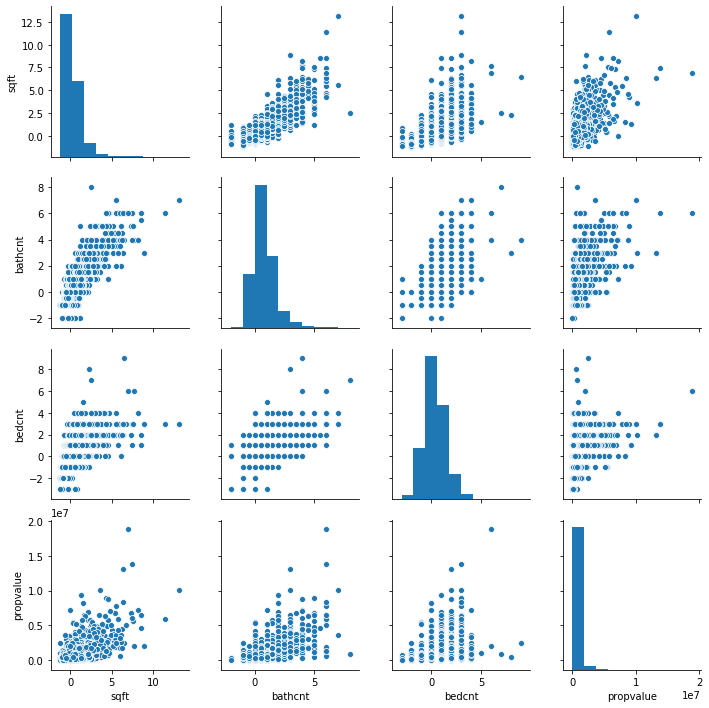

In [28]:
grid = sns.pairplot(train_combined, vars=["sqft","bathcnt","bedcnt","propvalue"])

#### CORRELATIONS

In [29]:
corrsqft, psqft = stats.pearsonr(train_combined.sqft, train_combined.propvalue)
corrbth, pbth = stats.pearsonr(train_combined.bathcnt, train_combined.propvalue)
corrbed, pbed = stats.pearsonr(train_combined.bedcnt, train_combined.propvalue)

pearsonr = [corrsqft, corrbth, corrbed]
pval = [psqft, pbth, pbed]

r_pval = pd.DataFrame({"pearsonr":pearsonr, "pvalue":pval})
r_pval

,pearsonr,pvalue
0,0.625903,0.000000e+00
1,0.539421,0.000000e+00
2,0.285748,1.296613e-205


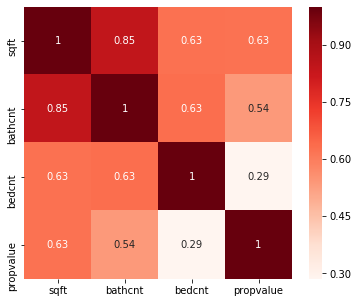

In [30]:
plt.figure(figsize=(6,5))
cor = train_combined.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)

#### TAKEAWAYS

**Features (X) to Target (y) Correlations**
- Square Footage on its own has a MODERATE POSITIVE correlation with Property Value
- Bathroom Count on its own has a MODERATE POSITIVE correlation with Property Value
- Bedroom Count on its own has a VERY LOW POSITIVE correlation with Property Value

**Features (x) to Features (x) Correlations**
- Square Footage and No. of Bathrooms have HIGH POSITIVE correlations with each other
- Square Footage and No. of Bedrooms have MODERATE POSITIVE correlations with each other

**Conclusion**  
Multicollinearity is apparent among the three features. With the Bathroom and Bedroom Count showing High and Moderate Positive Correlations towards the other feature Square Footage, not addressing these correlations might affect fitting the train data to the linear regression model.

To address this, PCA (Principal Component Analysis) will be used since PCA is designed to manage highly correlated variables by "combining" features linearly. Only the highest principal component, i.e., PC1 will be fed into the model.

### B. Feature Engineering

In [31]:
pca = PCA(n_components=3, copy=True, whiten=False, svd_solver='auto', random_state=123)
pca.fit(scaled_X_train)
pc3 = pca.transform(scaled_X_train)
pc3 = pd.DataFrame(pc3)

pc3_X_test = pca.transform(scaled_X_test)
pc3_X_test = pd.DataFrame(pc3_X_test)

print(pca.explained_variance_ratio_)

[0.8069304  0.14051593 0.05255367]


In [32]:
pc3.describe()

pc3_X_test.shape
pc3_X_test.head()

,0,1,2
0,-0.249273,-0.210303,-0.341366
1,-0.367398,-0.140443,0.243497
2,-2.622062,-1.123325,0.175822
3,-0.165273,0.904070,-0.141981
4,0.561196,-0.694679,-0.064808


## MODEL
PROJECT PLAN -> ACQUIRE -> PRE-PROCESS -> EXPLORE -> **MODEL**

In [33]:
lmo, lmo_intercept, lmo_coeff = util.generate_linear_model(pc3, y_train)

In [34]:
lmo

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [35]:
print(f"""
Intercept = {lmo_intercept}
Coefficients = {lmo_coeff}
""")


Intercept = 539087.1864653447
Coefficients = [ 249064.53278771 -313149.95615597  294617.52900653]



## III. Evaluate Models

1. Plot Residuals
2. Compute Evaluation Metrics
3. Compare Baseline and Ω Model
4. Plot y and yhat

Now, we have two models:  
- `lm_base` = baseline model
- `lmo` = Ω Model  
  
We will fit the test data, `scaled_X_test` into these two models to return predicted property values, that is, our ŷ.

In [36]:
#Call actual y from y_test
zillow_pd = pd.DataFrame(y_test.copy())

#Predict ŷ using Baseline and Ω Models
zillow_pd["y_base"] = lm_base.predict(scaled_X_test)
zillow_pd["y_omega"] = lmo.predict(pc3_X_test)

#Calculate Residuals of ŷ using Ω Model
zillow_pd["y_base_residuals"] = zillow_pd.propvalue - zillow_pd.y_base
zillow_pd["y_omega_residuals"] = zillow_pd.propvalue - zillow_pd.y_omega

In [37]:
zillow_pd.head()

,propvalue,y_base,y_omega,y_base_residuals,y_omega_residuals
24260,396304.0,534549.461280,442286.034483,-138245.461280,-45982.034483
30736,1184796.0,638339.459209,563299.488672,546456.540791,621496.511328
31683,284270.0,404330.960253,289593.993830,-120060.960253,-5323.993830
31007,559083.0,278126.405773,172983.895269,280956.594227,386099.104731
25754,649355.0,929168.638901,877306.477958,-279813.638901,-227951.477958


In [38]:
mse_baseline = mean_squared_error(zillow_pd.propvalue, zillow_pd.y_base)
rmse_baseline = sqrt(mse_baseline)
sse_baseline = mse_baseline * len(zillow_pd.propvalue)

mse_omega = mean_squared_error(zillow_pd.propvalue, zillow_pd.y_omega)
rmse_omega = sqrt(mse_omega)
sse_omega = mse_omega * len(zillow_pd.propvalue)

In [39]:
print(f"""
Baseline Model Error Metrics:
MSE: {mse_baseline}
RMSE: {rmse_baseline}
SSE: {sse_baseline}
""")

print(f"""
Ω Model Error Metrics:
MSE: {mse_omega}
RMSE: {rmse_omega}
SSE: {sse_omega}
""")


Baseline Model Error Metrics:
MSE: 438403466775.49805
RMSE: 662120.4322292871
SSE: 2065757135446146.8


Ω Model Error Metrics:
MSE: 427445539759.151
RMSE: 653793.1934175753
SSE: 2014123383345119.5



In [40]:
evs_baseline = explained_variance_score(zillow_pd.propvalue, zillow_pd.y_base)
evs_baseline

0.325610123610515

In [41]:
evs_omega = explained_variance_score(zillow_pd.propvalue, zillow_pd.y_omega)
evs_omega

0.3321125794176605

Text(0.5, 1, 'Predicted Property Value')

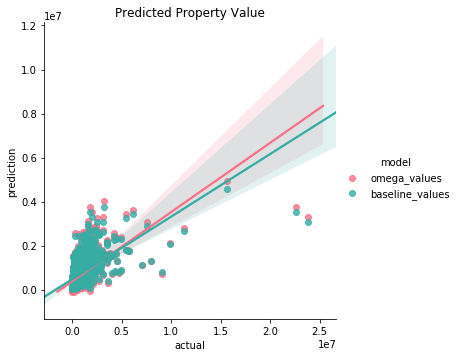

In [47]:
pd.DataFrame({'actual': zillow_pd.propvalue,
              'omega_values': zillow_pd.y_omega.ravel(),
              'baseline_values': zillow_pd.y_base.ravel()})\
.melt(id_vars='actual', var_name='model', value_name='prediction')\
.pipe((sns.lmplot, 'data'), x='actual', y='prediction', hue='model',palette="husl")
# .melt(id_vars=['actual'], var_name='model', value_name='prediction')\
# .pipe((sns.relplot, 'data'), x='x_test', y='prediction', hue='model')

# plt.ylim(min, max)
# plt.xlim(min, max)
plt.title('Predicted Property Value')